# 0. Import Lib

In [62]:
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.filters import frangi
from cv2 import erode, dilate
import cv2 as cv
from scipy.sparse import dok_matrix
import pandas as pd
import pandas
import networkx as nx
from sthype import SpatialGraph, SpatialTemporalGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs
from sthype.plot import plot_spatial_temporal_graph
from multiprocessing import Pool
import pickle
import os
import matplotlib as mpl

cmap = plt.cm.gray

# 1. Functions

In [2]:
def remove_component(dilated, min_size=4000):
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
        dilated.astype(np.uint8), connectivity=8
    )
    # connectedComponentswithStats yields every seperated component with information on each of them, such as size
    # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever

    # your answer image
    img_f = np.zeros((dilated.shape))
    # for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img_f[output == i + 1] = 1
    return np.array(255 * img_f, dtype=np.uint8)

def frangi_image(imarray, side=1000, margin=100):
    rows = []
    for i in range(margin, imarray.shape[0]-side-margin, side):
        row = []
        for j in range(margin, imarray.shape[1]-side-margin, side):
            print(i, j)
            sample = imarray[i-margin:i+side+margin, j-margin:j+side+margin]
            sampleimth = sample - morphology.white_tophat(sample, morphology.disk(2))
            sampleimth = sampleimth - morphology.black_tophat(sampleimth, morphology.disk(10))
            frangisample = frangi(sampleimth, gamma=0.01)
            new_im = np.where(frangisample>0.5, 1, 0).astype(np.uint8)
            new_im = dilate(new_im, np.ones((3, 3)), iterations=1)
            new_im = new_im[margin:side+margin, margin:side+margin]
            row.append(new_im)
        rows.extend(np.concatenate(row, axis=1))
    return np.array(rows)

def skeletonize_im(imarray, side=1000, margin=100, min_size=4000):
    frangiim = frangi_image(imarray, side, margin)
    skeleton = morphology.skeletonize(frangiim)
    return np.where(remove_component(255*(skeleton.astype(np.uint8)), min_size=min_size) < 122, 0, 1)

In [3]:
def extract_branches(doc_skel):
    def get_neighbours(pixel):
        x = pixel[0]
        y = pixel[1]
        primary_neighbours = {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}
        secondary_neighbours = {
            (x + 1, y - 1),
            (x + 1, y + 1),
            (x - 1, y + 1),
            (x - 1, y - 1),
        }
        num_neighbours = 0
        actual_neighbours = []
        for neighbour in primary_neighbours:
            if neighbour in non_zero_pixel:
                num_neighbours += 1
                xp = neighbour[0]
                yp = neighbour[1]
                primary_neighboursp = {
                    (xp + 1, yp),
                    (xp - 1, yp),
                    (xp, yp + 1),
                    (xp, yp - 1),
                }
                for neighbourp in primary_neighboursp:
                    secondary_neighbours.discard(neighbourp)
                actual_neighbours.append(neighbour)
        for neighbour in secondary_neighbours:
            if neighbour in non_zero_pixel:
                num_neighbours += 1
                actual_neighbours.append(neighbour)
        return (actual_neighbours, num_neighbours)

    pixel_branch_dic = {pixel: set() for pixel in doc_skel.keys()}
    is_node = {pixel: False for pixel in doc_skel.keys()}
    pixel_set = set(doc_skel.keys())
    non_zero_pixel = doc_skel
    new_index = 1
    non_explored_direction = set()
    while len(pixel_set) > 0:
        is_new_start = len(non_explored_direction) == 0
        if is_new_start:
            pixel = pixel_set.pop()
        else:
            pixel = non_explored_direction.pop()
        actual_neighbours, num_neighbours = get_neighbours(pixel)
        if is_new_start:
            if num_neighbours == 2:
                new_index += 1
                pixel_branch_dic[pixel] = {new_index}
        is_node[pixel] = num_neighbours in [0, 1, 3, 4]
        pixel_set.discard(pixel)
        #!!! This is to solve the two neighbours nodes problem
        if is_node[pixel]:
            for neighbour in actual_neighbours:
                if is_node[neighbour]:
                    new_index += 1
                    pixel_branch_dic[pixel].add(new_index)
                    pixel_branch_dic[neighbour].add(new_index)
            continue
        else:
            for neighbour in actual_neighbours:
                if neighbour in pixel_set:
                    non_explored_direction.add(neighbour)
                pixel_branch_dic[neighbour] = pixel_branch_dic[neighbour].union(
                    pixel_branch_dic[pixel]
                )
    return (pixel_branch_dic, is_node, new_index)

def get_neighbours2(pixel, xs, ys):
    x = pixel[0]
    y = pixel[1]
    primary_neighbours = {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}
    secondary_neighbours = {
        (x + 1, y - 1),
        (x + 1, y + 1),
        (x - 1, y + 1),
        (x - 1, y - 1),
    }
    pixel_list = [(x, ys[i]) for i, x in enumerate(xs)]
    num_neighbours = 0
    actual_neighbours = set()
    for neighbour in primary_neighbours:
        if neighbour in pixel_list:
            xp = neighbour[0]
            yp = neighbour[1]
            primary_neighboursp = {
                (xp + 1, yp),
                (xp - 1, yp),
                (xp, yp + 1),
                (xp, yp - 1),
            }
            for neighbourp in primary_neighboursp:
                secondary_neighbours.discard(neighbourp)
            actual_neighbours.add(neighbour)
    for neighbour in secondary_neighbours:
        if neighbour in pixel_list:
            actual_neighbours.add(neighbour)
    return actual_neighbours

def order_pixel(pixel_begin, pixel_end, pixel_list):
    ordered_list = [pixel_begin]
    current_pixel = pixel_begin
    precedent_pixel = pixel_begin
    xs = [pixel[0] for pixel in pixel_list]
    ys = [pixel[1] for pixel in pixel_list]

    while current_pixel != pixel_end:
        neighbours = get_neighbours2(current_pixel, np.array(xs), np.array(ys))
        neighbours.discard(precedent_pixel)
        precedent_pixel = current_pixel
        current_pixel = neighbours.pop()
        ordered_list.append(current_pixel)
    return ordered_list

def from_sparse_to_graph(doc_skel):
    column_names = ["origin", "end", "pixel_list"]
    graph = pd.DataFrame(columns=column_names)
    pixel_branch_dic, is_node, new_index = extract_branches(doc_skel)
    nodes = []
    edges = {}
    for pixel in pixel_branch_dic:
        for branch in pixel_branch_dic[pixel]:
            right_branch = branch
            if right_branch not in edges.keys():
                edges[right_branch] = {"origin": [], "end": [], "pixel_list": [[]]}
            if is_node[pixel]:
                if len(edges[right_branch]["origin"]) == 0:
                    edges[right_branch]["origin"] = [pixel]
                else:
                    edges[right_branch]["end"] = [pixel]
            edges[right_branch]["pixel_list"][0].append(pixel)
    for branch in edges:
        if len(edges[branch]["origin"]) > 0 and len(edges[branch]["end"]) > 0:
            # TODO(FK): Use pandas.concat instead (Frame.append soon deprecated)
            # graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)
            graph = pandas.concat([graph, pd.DataFrame(edges[branch])])
    for index, row in graph.iterrows():
        row["pixel_list"] = order_pixel(row["origin"], row["end"], row["pixel_list"])
    return graph

def generate_set_node(graph_tab):
    nodes = set()
    for index, row in graph_tab.iterrows():
        nodes.add(row["origin"])
        nodes.add(row["end"])
    return sorted(nodes)


def generate_nx_graph(graph_tab, labeled=False):
    G = nx.Graph()
    pos = {}
    if not labeled:
        nodes = generate_set_node(graph_tab)
    for index, row in graph_tab.iterrows():
        if labeled:
            identifier1 = row["origin_label"]
            identifier2 = row["end_label"]
            pos[identifier1] = np.array(row["origin_pos"]).astype(np.int32)
            pos[identifier2] = np.array(row["end_pos"]).astype(np.int32)
        else:
            identifier1 = nodes.index(row["origin"])
            identifier2 = nodes.index(row["end"])
            pos[identifier1] = np.array(row["origin"]).astype(np.int32)
            pos[identifier2] = np.array(row["end"]).astype(np.int32)
        info = {"weight": len(row["pixel_list"]), "pixel_list": row["pixel_list"]}
        G.add_edges_from([(identifier1, identifier2, info)])
    return (G, pos)

In [4]:
def graph_from_skeleton(skeleton):
    skeleton_dok = dok_matrix(skeleton)
    graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton_dok))
    nx.set_node_attributes(graph, pos, 'position')
    for _, _, data in graph.edges(data=True):
        data["pixels"] = data.pop("pixel_list")
    return graph

# 2. Import Images

In [5]:
im = Image.open('/home/ipausers/hamzaoui/Documents/Data/Louis/Louis TimeLapse/Original/Timelapse_1.tif')
images = []
for i, page in enumerate(ImageSequence.Iterator(im)):
    if i >= 8:
        break
    images.append(np.array(page)/(2**14-1))

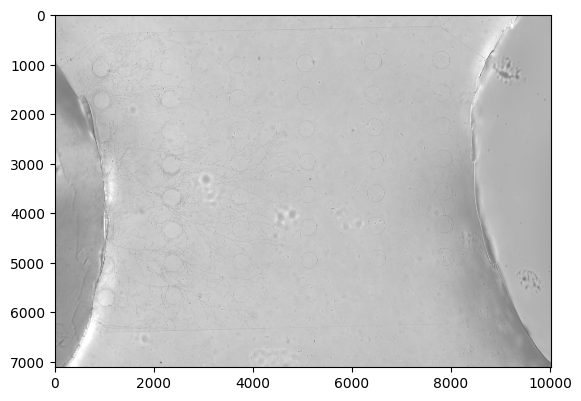

In [65]:
image0 = images[0]
image0 = image0 - morphology.white_tophat(image0, morphology.disk(2))
image0 = image0 - morphology.black_tophat(image0, morphology.disk(10))
plt.imshow(image0, cmap=cmap);

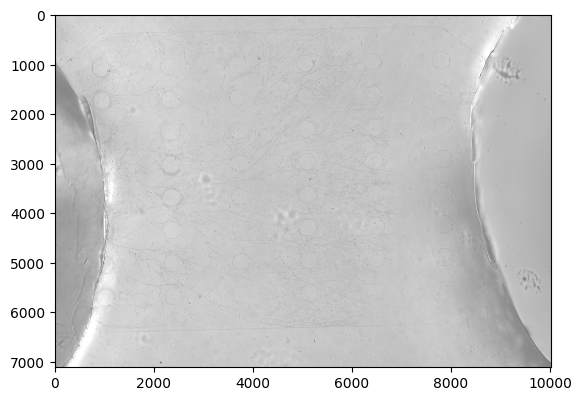

In [67]:
image7 = images[7]
image7 = image7 - morphology.white_tophat(image7, morphology.disk(2))
image7 = image7 - morphology.black_tophat(image7, morphology.disk(10))
plt.imshow(image7, cmap=cmap);

# 3. Sample Test

## 3.1 Skeleton

In [33]:
skeletons = []
for i, image in enumerate(images):
    print('Image', i+1, '/', len(images))
    skeletons.append(skeletonize_im(image[2000:4500, 2000:4500], 1000, 100))

Image 1 / 3
100 100
100 1100
1100 100
1100 1100
Image 2 / 3
100 100
100 1100
1100 100
1100 1100
Image 3 / 3
100 100
100 1100
1100 100
1100 1100


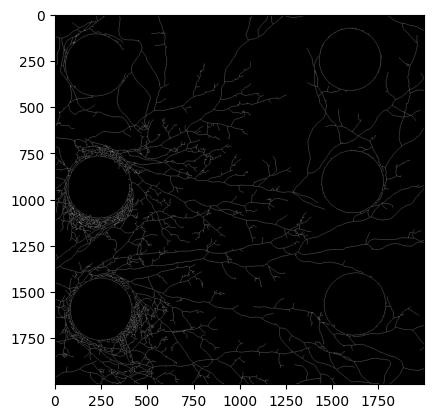

In [63]:
plt.imshow(skeletons[0], cmap=cmap)

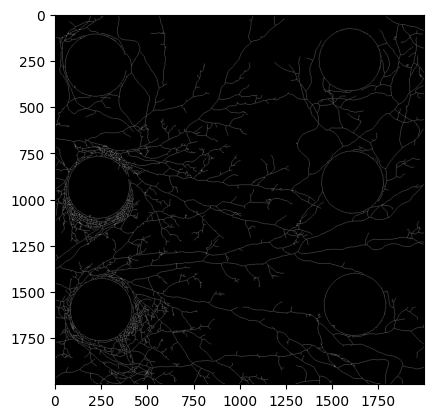

In [68]:
plt.imshow(skeletons[2], cmap=cmap)

## 3.2 Graphs

In [48]:
graphs = []
positions = []
for skeleton in skeletons:
    skeleton_dok = dok_matrix(skeleton)
    graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton_dok))
    nx.set_node_attributes(graph, pos, 'position')
    for _, _, data in graph.edges(data=True):
        data["pixels"] = data.pop("pixel_list")
    graphs.append(graph)
    positions.append(pos)

In [50]:
spatial_graphs = [SpatialGraph(graph) for graph in graphs]
spatial_graph = spatial_graphs[-1]
sg = spatial_graph

## 3.3 Spatial Temporal Graph

In [73]:
spatial_temporal_graph = spatial_temporal_graph_from_spatial_graphs(spatial_graphs, np.arange(len(spatial_graphs)), threshold=50, segments_length=50, verbose=1)
stg = spatial_temporal_graph

Segmentation
Edge Activation
Comparing with graph 2
Comparing with graph 1
Comparing with graph 0


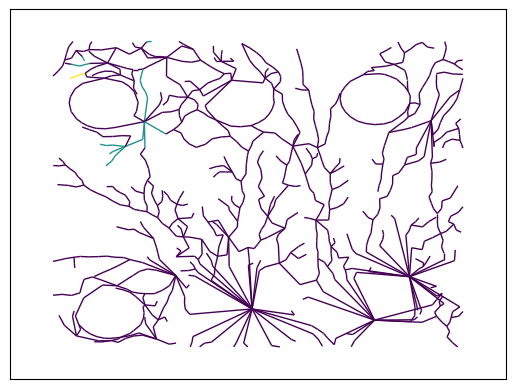

In [74]:
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='activation')

# 4. Full Image (Low TimeStep)

## 4.1 Skeletonize

In [81]:
with Pool() as pool:
    skeletons = pool.map(skeletonize_im, images[:3])

100 100
100 100
100 100
100 1100
100 1100
100 1100
100 2100
100 2100
100 2100
100 3100
100 3100
100 3100
100 4100
100 4100
100 4100
100 5100
100 5100
100 5100
100 6100
100 6100
100 6100
100 7100
100 7100
100 7100
100 8100
100 8100
100 8100
1100 100
1100 100
1100 100
1100 1100
1100 1100
1100 1100
1100 2100
1100 2100
1100 2100
1100 3100
1100 3100
1100 3100
1100 4100
1100 4100
1100 4100
1100 5100
1100 5100
1100 5100
1100 6100
1100 6100
1100 6100
1100 7100
1100 7100
1100 7100
1100 8100
1100 8100
1100 8100
2100 100
2100 100
2100 100
2100 1100
2100 1100
2100 1100
2100 2100
2100 2100
2100 2100
2100 3100
2100 3100
2100 3100
2100 4100
2100 4100
2100 4100
2100 5100
2100 5100
2100 5100
2100 6100
2100 6100
2100 6100
2100 7100
2100 7100
2100 7100
2100 8100
2100 8100
2100 8100
3100 100
3100 100
3100 100
3100 1100
3100 1100
3100 1100
3100 2100
3100 2100
3100 2100
3100 3100
3100 3100
3100 3100
3100 4100
3100 4100
3100 4100
3100 5100
3100 5100
3100 5100
3100 6100
3100 6100
3100 6100
3100 7100
3100 7100

## 4.2 Graphs

In [88]:
with Pool() as pool:
    graphs = pool.map(graph_from_skeleton, skeletons)

spatial_graphs = [SpatialGraph(graph) for graph in graphs]
spatial_graph = spatial_graphs[-1]
sg = spatial_graph

## 4.3 Stg

In [89]:
spatial_temporal_graph = spatial_temporal_graph_from_spatial_graphs(spatial_graphs, np.arange(len(spatial_graphs)), threshold=50, segments_length=20, verbose=1)
stg = spatial_temporal_graph

Segmentation
Edge Activation
Comparing with graph 2
Comparing with graph 1
Comparing with graph 0


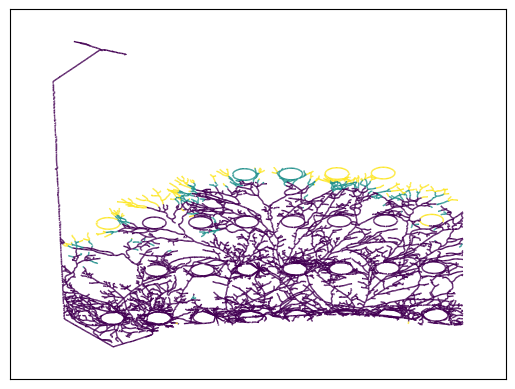

In [90]:
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='activation')

# 5. Full Image, All TimeSteps

## 5.1 Save Graphs

In [7]:
with Pool() as pool:
    skeletons = pool.map(skeletonize_im, images)

100 100
100 100
100 100
100 100
100 1100
100 100
100 100
100 1100
100 1100
100 100
100 100
100 1100
100 2100
100 1100
100 2100
100 1100
100 2100
100 1100
100 1100
100 2100
100 2100
100 3100
100 2100
100 3100
100 3100
100 2100
100 2100
100 3100
100 3100
100 4100
100 4100
100 3100
100 4100
100 3100
100 3100
100 4100
100 4100
100 5100
100 5100
100 4100
100 4100
100 5100
100 5100
100 5100
100 4100
100 6100
100 6100
100 5100
100 6100
100 5100
100 6100
100 6100
100 5100
100 7100
100 7100
100 6100
100 6100
100 7100
100 7100
100 7100
100 6100
100 8100
100 8100
100 7100
100 8100
100 7100
100 8100
100 8100
100 7100
1100 100
1100 100
100 8100
1100 100
100 8100
1100 100
1100 100
100 8100
1100 1100
1100 1100
1100 100
1100 11001100
 1100
1100 100
1100 1100
1100 100
1100 2100
1100 2100
1100 1100
1100 2100
1100 2100
1100 1100
1100 2100
1100 1100
1100 3100
1100 3100
1100 2100
1100 3100
1100 3100
1100 2100
1100 3100
1100 2100
1100 4100
1100 4100
1100 3100
1100 4100
1100 4100
1100 4100
1100 3100
1100 310

In [9]:
with Pool() as pool:
    graphs = pool.map(graph_from_skeleton, skeletons)

for i, graph in enumerate(graphs):
    pickle.dump(graph, open(f'/home/ipausers/hamzaoui/Documents/Data/Louis/Louis TimeLapse/Graphs/Timelapse_1/graph_{i:03}.p', 'wb'))

## 5.2 STG

In [19]:
graphs2 = []

str_directory = "/home/ipausers/hamzaoui/Documents/Data/Louis/Louis TimeLapse/Graphs/Timelapse_1"
directory = os.fsencode(str_directory)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    file_path = os.path.join(str_directory, filename)
    if filename.endswith('p'):
        graphs2.append((filename, pickle.load(open(file_path, 'rb'))))

graphs2.sort()
graphs2 = [graph for _, graph in graphs2]

In [25]:
spatial_graphs = [SpatialGraph(graph) for graph in graphs]
spatial_graph = spatial_graphs[-1]
sg = spatial_graph
spatial_temporal_graph = spatial_temporal_graph_from_spatial_graphs(spatial_graphs, np.arange(len(spatial_graphs)), threshold=50, segments_length=20, verbose=1)
stg = spatial_temporal_graph

Segmentation
Edge Activation
Comparing with graph 7
Comparing with graph 6
Comparing with graph 5
Comparing with graph 4
Comparing with graph 3
Comparing with graph 2
Comparing with graph 1
Comparing with graph 0


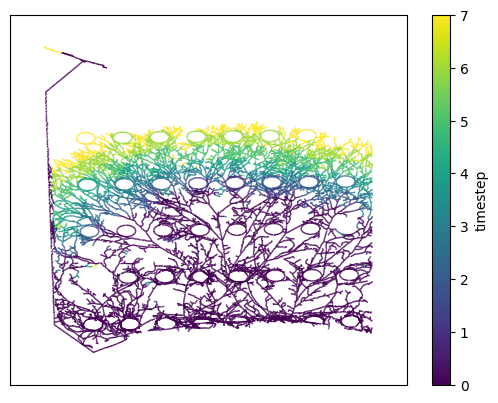

In [46]:
fig, ax = plt.subplots()
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='activation', edge_cmap=cmap, ax=ax)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 7), cmap=mpl.cm.viridis),
             ax=ax, orientation='vertical', label='timestep');

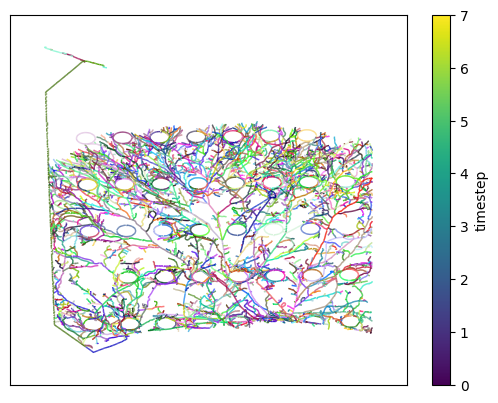

In [48]:
fig, ax = plt.subplots()
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='hyperedge', edge_cmap=cmap, ax=ax)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 7), cmap=mpl.cm.viridis),
             ax=ax, orientation='vertical', label='timestep');

In [47]:
pickle.dump(nx.Graph(stg), open(f'/home/ipausers/hamzaoui/Documents/Data/Louis/Louis TimeLapse/Spatial_Temporal_Graph/stg_timelapse1_8timesteps.p', 'wb'))